In [1]:
import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=16)        
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42449 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42449/status,
Dashboard: /proxy/42449/status,Workers: 16
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39203,Workers: 16
Dashboard: /proxy/42449/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:33483,Total threads: 1
Dashboard: /proxy/34605/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:45213,


### First, get the shelf mask

CPU times: user 10.7 s, sys: 3.65 s, total: 14.3 s
Wall time: 43.5 s


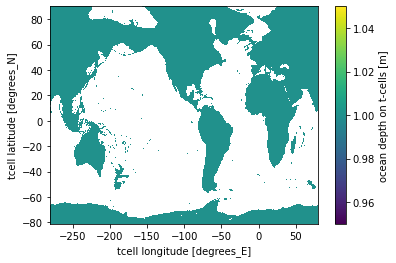

In [2]:
%%time
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu; above1000 = field.where(field >= 1000,1); above1000_ucells = above1000.where(above1000 < 1000, drop=False) 
above1000_tcells.plot()
# Wall time: 37.5 s

### Loading in the heat budget terms

In [3]:
%%time 
base   = '/g/data/e14/mv7494/access-om2/archive/'
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_LNFull']
# --------------------------------------------------------------------------------------------------------------------------------- #
depth     = [  23,   47]  # [ 23,   47] = 97.6 m - 1017 m, [24,   40] = 108.9 - 517.6 m                                             #
sel_lat   = [   0,  500]  # [120,  263] = 76.03°S - 70.04°S                                                                         #
sel_lon   = [1299, 2200]  # 150°W - 60°W                                                                                            #
rho_0     = 1035          # reference density [1035 kg * m^-3]                                                                      #
C_p       = 3992.1        # reference specific heat capacity [3992.1 J * kg^-1 * K^-1]                                              #
area_t    = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_grid.nc').area_t[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]    #
dyu       = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_grid.nc').dyu[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]       #
dxu       = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_grid.nc').dxu[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]       #
# --------------------------------------------------------------------------------------------------------------------------------- #

# load in variables
average_DT = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_month.nc', decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 
average_DT # 2592000.0 s per time step

temp_tendency_clim    = xr.open_mfdataset(base+exp[0]+'/output*/ocean/ocean_heat.nc').temp_tendency[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_tendency_LN      = xr.open_mfdataset(base+exp[1]+'/output*/ocean/ocean_heat.nc').temp_tendency[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_tendency         = ((temp_tendency_LN - temp_tendency_clim) * above1000_tcells * area_t * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()

# now the same for the heat flux convergence
temp_advection_clim    = xr.open_mfdataset(base+exp[0]+'/output*/ocean/ocean_heat.nc').temp_advection[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_advection_LN      = xr.open_mfdataset(base+exp[1]+'/output*/ocean/ocean_heat.nc').temp_advection[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_advection         = ((temp_advection_LN - temp_advection_clim) * above1000_tcells * area_t * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()


CPU times: user 6.26 s, sys: 939 ms, total: 7.2 s
Wall time: 26.1 s


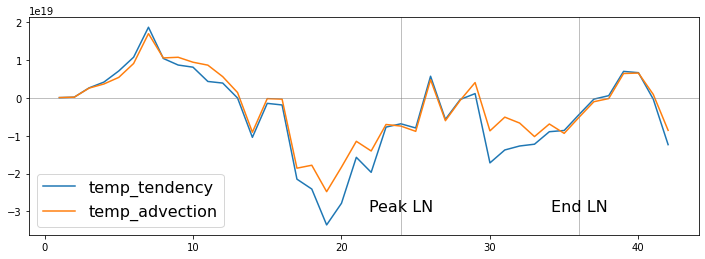

In [4]:
plt.figure(figsize=(12,4)); time = np.linspace(1,len(temp_tendency),len(temp_tendency))
plt.plot(time, temp_tendency, label='temp_tendency')
plt.plot(time, temp_advection, label='temp_advection')
plt.axhline(0, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5); plt.text(24,-3e19,'Peak LN', ha='center', fontsize=16)
plt.axvline(36, c='grey', lw=.5); plt.text(36,-3e19,'End LN', ha='center', fontsize=16)
plt.legend(fontsize=16)

-----------------------------------------------------------------------------------------

### Okay, so far, so good!

### Next, loading in the transport masks

CPU times: user 174 ms, sys: 20.4 ms, total: 195 ms
Wall time: 175 ms


Text(0.5, 1.0, 'mask_x_1000m_isobath')

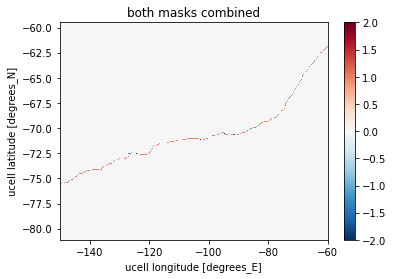

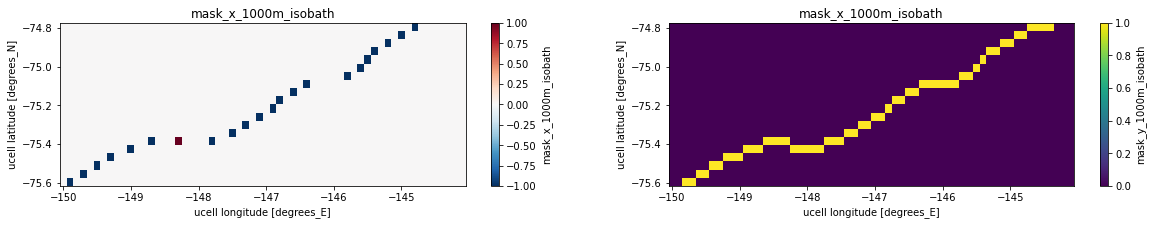

In [5]:
%%time
# loading in the transport masks from Claire's script called 'Cross-contour_transport.ipynb'
# her original script is in the COSIMA recipe repo: https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Cross-contour_transport.html
base_mask = '/g/data/e14/mv7494/ACCESS-OM2-01_transport_masks/'
mask_x_transport_ucells = xr.open_dataset(base_mask + 'mask_x_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_x_1000m_isobath.rename(
    {'y_ocean': 'yu_ocean', 'x_ocean': 'xu_ocean'})[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
mask_y_transport_ucells = xr.open_dataset(base_mask + 'mask_y_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_y_1000m_isobath.rename(
    {'y_ocean': 'yu_ocean', 'x_ocean': 'xu_ocean'})[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
(mask_x_transport_ucells+mask_y_transport_ucells).plot(); plt.title('both masks combined')
plt.figure(figsize=(20,3)); plt.subplot(1,2,1); mask_x_transport_ucells[130:150,:60].plot(); plt.title('mask_x_1000m_isobath')
plt.subplot(1,2,2); mask_y_transport_ucells[130:150,:60].plot(); plt.title('mask_x_1000m_isobath')

### Loading in the variables to calculate the cross-shelf heat fluxes

In [6]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']

# ---------------------------------------------------------------------------------- #
for e in [2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 2: last_output = 989; nr_outputs = 14 # La Nina simulation goes from output976 to output989

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 
        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]
        
    # average time in seconds per month (the output is saved in ns, that's why /1e9)      
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    # the same for the two velocities
    u_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    u        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    v_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).v[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    v        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).v[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    dzt      = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).dzt[0, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 2: 
        # interpolate the temperatures onto the u-grid (yu_ocean, xu_ocean)
        temp_LN_anom = (temp  - temp_clim).interp(yt_ocean=u.yu_ocean.values,xt_ocean=u.xu_ocean.values,method='linear').rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
        u_LN_anom    = (u     - u_clim)
        v_LN_anom    = (v     - v_clim)
        # and the same for the cell thickness
        dzu_LN       = dzt.interp(yt_ocean=u.yu_ocean.values,xt_ocean=u.xu_ocean.values,method='linear').rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
print('----------------------------------')
# Wall time: 30.4 s

01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 11.1 s, sys: 1.03 s, total: 12.1 s
Wall time: 11.2 s


### Here the heavy lifting (i.e., calculating the poleward cross-shelf heat flux across the 1000 m isobath)
$\rightarrow$ for now without the uncertainty

In [7]:
%%time
# here the calculation of the across-shelf heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) ----------------------------------------------- #
across_x_flux = (rho_0 * C_p * u_LN_anom * temp_LN_anom * dzu_LN * dyu * average_DT * mask_x_transport_ucells).sum(['st_ocean', 'yu_ocean', 'xu_ocean']).load()
across_y_flux = (rho_0 * C_p * v_LN_anom * temp_LN_anom * dzu_LN * dxu * average_DT * mask_y_transport_ucells).sum(['st_ocean', 'yu_ocean', 'xu_ocean']).load()
across_heat_flux = (across_x_flux+across_y_flux)
# Wall time: 

CPU times: user 7.2 s, sys: 1.13 s, total: 8.33 s
Wall time: 38.3 s


CPU times: user 41.6 ms, sys: 5.86 ms, total: 47.5 ms
Wall time: 42.9 ms


Text(0, 0.5, '(Jmonth$^{-1}$)')

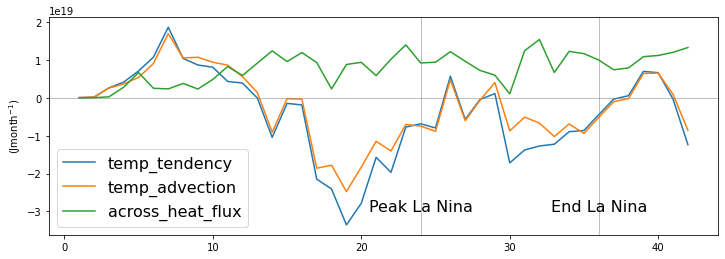

In [8]:
%%time
plt.figure(figsize=(12,4)); time = np.linspace(1,len(temp_tendency),len(temp_tendency))
plt.plot(time, temp_tendency, label='temp_tendency')
plt.plot(time, temp_advection, label='temp_advection')
plt.plot(time, across_heat_flux*-1, label='across_heat_flux')
plt.axhline(0, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5); plt.text(24,-3e19,'Peak La Nina', ha='center', fontsize=16)
plt.axvline(36, c='grey', lw=.5); plt.text(36,-3e19,'End La Nina', ha='center', fontsize=16)
plt.legend(fontsize=16); plt.ylabel('(Jmonth$^{-1}$)')
# Wall time: 

In [9]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #